In [2]:
import json

import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from scipy.stats import kendalltau

In [3]:
languages = ['en', 'de']
models_results_path_format = "model_outputs/2/%s.json"
models = {
    'Aya': 'aya',
    'Gemma 2B': 'gemma2B',
    'Gemma 9B': 'gemma',
    'LLaMa 3.1': 'llama31',
    'Mistral': 'mistral',
    'Openchat3.5': 'openchat',
    'Qwen': 'qwen',
    'Yi': 'yi',
}

In [4]:
def load_results(path):
    with open(path, 'r') as file:
        return json.load(file)

In [5]:
def preprocess_json(data):
    proper_data = []
    for lang in data:
        for r in data[lang]:
            r['lang'] = lang
            if 'quillbot_errors' not in r:
                r['quillbot_errors'] = None
            proper_data.append(r)
    return proper_data

In [6]:
original_dataset = preprocess_json(load_results("results.json"))
model_datasets = {m: preprocess_json(load_results(models_results_path_format % p)) for m, p in models.items()}

In [7]:
def get_df(data, model_name):
    df = pd.DataFrame(data)

    df['model'] = model_name

    df = df[df['lang'].isin(languages)]

    if 'path' in df.columns:
        df = df.drop(columns='path')

    df = df[(~df['id'].str.endswith("(1).txt"))]
    df = df[(~df['content'].str.isupper())]

    df['id'] = df['id'].apply(lambda x: x.replace(".txt", "").split("_")[1]).astype(int)

    df['word_count'] = df['content'].apply(lambda x: len(x.split()))
    df['score'] = 1 - (df['quillbot_errors'] / df['word_count'])

    return df

In [8]:
df = get_df(original_dataset, "original_dataset")
for model, data in model_datasets.items():
    df = pd.concat((df, get_df(data, model)))
df = df.sort_values('id')

In [9]:
df.head(20)

,id,content,label,quillbot_errors,lang,model,word_count,score
150,0,13th June 2000 \n,correct,0.0,en,Gemma 9B,3,1.000000
150,0,13th June 2000,correct,0.0,en,Openchat3.5,3,1.000000
8651,0,Die meisten Universitätsabschlüsse sind nicht ...,correct,11.0,de,Yi,71,0.845070
9055,0,4 Die meisten Universitätsabschlüsse sind nich...,correct,1.0,de,original_dataset,17,0.941176
150,0,"June 13, 2000",correct,0.0,en,Aya,3,1.000000
8651,0,Die meisten universitären Abschlüsse sind nich...,correct,0.0,de,Gemma 2B,17,1.000000
150,0,"June 13, 2000 \n",correct,0.0,en,Gemma 2B,3,1.000000
8651,0,Die meisten Universitätsabschlüsse sind nicht ...,correct,1.0,de,Qwen,18,0.944444
150,0,13 June 2000,correct,0.0,en,LLaMa 3.1,3,1.000000
8651,0,Die meisten Universitätsabschlüsse sind nicht ...,correct,0.0,de,LLaMa 3.1,16,1.000000


In [10]:
def plot_hist(d):
    plt.hist(d[d['label'] == 'correct']['score'], label='correct', alpha=0.5, bins=10)
    plt.hist(d[d['label'] == 'incorrect']['score'], label='incorrect', alpha=0.5, bins=10)
    plt.legend(loc='upper left')
    plt.show()

## Results

In [11]:
mean_scores = (
    df
    .groupby(['model', 'lang'])['score']
    .mean()
    .reset_index()
    .pivot(index='model', columns='lang', values='score')
    .reset_index()
)
mean_scores

lang,model,de,en
0,Aya,0.969895,0.954598
1,Gemma 2B,0.960141,0.984133
2,Gemma 9B,0.972174,0.977207
3,LLaMa 3.1,0.966889,0.966827
4,Mistral,0.899287,0.971860
5,Openchat3.5,0.958678,0.982082
6,Qwen,0.934562,0.981479
7,Yi,0.883081,0.976637
8,original_dataset,0.875213,0.893109


In [12]:
baseline = mean_scores.loc[mean_scores['model'] == 'original_dataset', languages].to_dict('records')[0]
rankings = {
    l: mean_scores[l].rank(ascending=False, method='min').astype(int) for l in languages
}

In [13]:
for l in languages:
    mean_scores[l] = mean_scores.apply(lambda row: f"{row[l]:.3f} ({rankings[l][row.name]})", axis=1)

mean_scores = (
    mean_scores[mean_scores['model'] != 'original_dataset']
    .rename(columns={lang: f"{lang} ({baseline[lang]:.3f})" for lang in languages})
    .rename(columns={'model': 'Model'})
    .round(3)
)
print(mean_scores.to_string(index=False))

      Model de (0.875) en (0.893)
        Aya  0.970 (2)  0.955 (8)
   Gemma 2B  0.960 (4)  0.984 (1)
   Gemma 9B  0.972 (1)  0.977 (4)
  LLaMa 3.1  0.967 (3)  0.967 (7)
    Mistral  0.899 (7)  0.972 (6)
Openchat3.5  0.959 (5)  0.982 (2)
       Qwen  0.935 (6)  0.981 (3)
         Yi  0.883 (8)  0.977 (5)


In [14]:
print(tabulate(mean_scores, headers='keys', tablefmt='latex', showindex=False))

\begin{tabular}{lll}
\hline
 Model       & de (0.875)   & en (0.893)   \\
\hline
 Aya         & 0.970 (2)    & 0.955 (8)    \\
 Gemma 2B    & 0.960 (4)    & 0.984 (1)    \\
 Gemma 9B    & 0.972 (1)    & 0.977 (4)    \\
 LLaMa 3.1   & 0.967 (3)    & 0.967 (7)    \\
 Mistral     & 0.899 (7)    & 0.972 (6)    \\
 Openchat3.5 & 0.959 (5)    & 0.982 (2)    \\
 Qwen        & 0.935 (6)    & 0.981 (3)    \\
 Yi          & 0.883 (8)    & 0.977 (5)    \\
\hline
\end{tabular}


#### Correlation between rankings?

In [15]:
language_tool_results = [
    {
        'model': 'Aya',
        'en': 0.919,
        'de': 0.972
    },
    {
        'model': 'Gemma 2B',
        'en': 0.963,
        'de': 0.951
    },
    {
        'model': 'Gemma 9B',
        'en': 0.949,
        'de': 0.940
    },
    {
        'model': 'LLaMa 3.1',
        'en': 0.939,
        'de': 0.958
    },
    {
        'model': 'Mistral',
        'en': 0.958,
        'de': 0.895
    },
    {
        'model': 'Openchat3.5',
        'en': 0.948,
        'de': 0.954
    },
    {
        'model': 'Qwen',
        'en': 0.963,
        'de': 0.924
    },
    {
        'model': 'Yi',
        'en': 0.774,
        'de': 0.780
    },
    {
        'model': 'Original Dataset',
        'en': 0.754,
        'de': 0.740
    }
]

lt_df = pd.DataFrame(language_tool_results)
lt_df

,model,en,de
0,Aya,0.919,0.972
1,Gemma 2B,0.963,0.951
2,Gemma 9B,0.949,0.940
3,LLaMa 3.1,0.939,0.958
4,Mistral,0.958,0.895
5,Openchat3.5,0.948,0.954
6,Qwen,0.963,0.924
7,Yi,0.774,0.780
8,Original Dataset,0.754,0.740


In [16]:
lt_rankings = {
    l: lt_df[l].rank(ascending=False, method='min').astype(int) for l in languages
}

In [17]:
for l in languages:
    print("Kendall's tau for", l)
    print(kendalltau(rankings[l].values, lt_rankings[l].values))

Kendall's tau for en
SignificanceResult(statistic=0.5916079783099616, pvalue=0.027707849358079868)
Kendall's tau for de
SignificanceResult(statistic=0.7222222222222222, pvalue=0.0058862433862433864)


## English

In [18]:
print("correct only")
df[(df['lang'] == 'en')
   & (df['label'] == 'correct')][['score', 'model']].groupby('model').mean().sort_values('score', ascending=False)

correct only


,score
model,
Gemma 2B,0.987716
Openchat3.5,0.983645
Qwen,0.982885
Yi,0.979438
Gemma 9B,0.979333
LLaMa 3.1,0.975915
Aya,0.968800
Mistral,0.965833
original_dataset,0.936599


In [19]:
print("incorrect only")
df[(df['lang'] == 'en')
   & (df['label'] == 'incorrect')][['score', 'model']].groupby('model').mean().sort_values('score', ascending=False)

incorrect only


,score
model,
Gemma 2B,0.981634
Openchat3.5,0.980981
Qwen,0.980484
Mistral,0.976109
Gemma 9B,0.975711
Yi,0.974659
LLaMa 3.1,0.960434
Aya,0.944669
original_dataset,0.862416


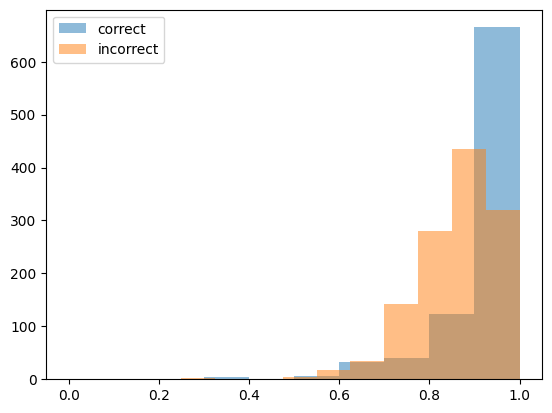

In [20]:
plot_hist(df[(df['lang'] == 'en') & (df['model'] == 'original_dataset')])

In [21]:
df[(df['lang'] == 'en')
   & (df['model'] == 'original_dataset')
   & (df['score'] != 1)
   & (df['label'] == 'correct')][['content', 'score']].sort_values('score')

,content,score
2152,Ms MARIA AROZ,0.000000
1107,"13th June, 2000",0.333333
2113,"DEAR Helen Ryan,",0.333333
1206,Dear Mr Robertson.,0.333333
1079,"13th June, 2000",0.333333
...,...,...
1113,"I've never been camping before, I guess I'm no...",0.961538
349,I am very proud that I won first prize in your...,0.962963
2022,"With regard to the date of the trip, July woul...",0.964286
2003,We would have to forgo the shopping as we migh...,0.964286


## German

In [22]:
print("correct only")
df[(df['lang'] == 'de')
   & (df['label'] == 'correct')][['score', 'model']].groupby('model').mean().sort_values('score', ascending=False)

correct only


,score
model,
Aya,0.977342
LLaMa 3.1,0.972631
Gemma 9B,0.969466
Gemma 2B,0.966449
Openchat3.5,0.965781
original_dataset,0.953550
Qwen,0.921842
Mistral,0.906347
Yi,0.897352


In [23]:
print("incorrect only")
df[(df['lang'] == 'de')
   & (df['label'] == 'incorrect')][['score', 'model']].groupby('model').mean().sort_values('score', ascending=False)

incorrect only


,score
model,
Gemma 9B,0.973063
Aya,0.967451
LLaMa 3.1,0.965003
Gemma 2B,0.958069
Openchat3.5,0.956346
Qwen,0.938746
Mistral,0.896968
Yi,0.878393
original_dataset,0.849476


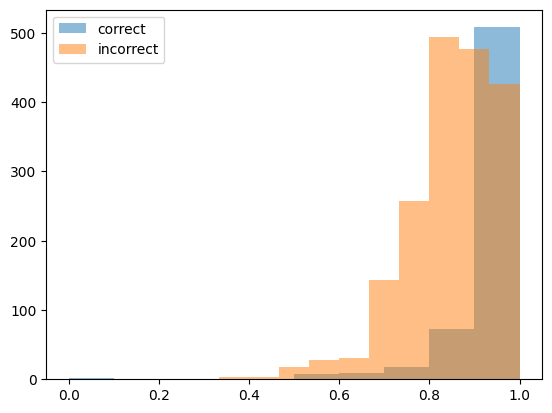

In [24]:
plot_hist(df[(df['lang'] == 'de') & (df['model'] == 'original_dataset')])

In [25]:
df[(df['lang'] == 'de')
   & (df['model'] == 'original_dataset')
   & (df['score'] != 1)
   & (df['label'] == 'correct')][['content', 'score']].sort_values('score')

,content,score
8798,gekauft.,0.000000
8847,online.,0.000000
6665,Hoffentlich bis bald Katharina 27.02.2012,0.400000
6984,Viele Grüße.,0.500000
9140,war schön.,0.500000
...,...,...
8686,Dieses Phänomen ist ein wichtiges Problem in a...,0.960000
8859,"In diesem Text „Ist es sinnvoll, auch im Ausla...",0.960000
8663,"Ich denke besonders an die vielen Kinder, Taus...",0.961538
9047,"Ich werde von meinen Bekannten danach gefragt,...",0.962963
